## Comparison of MPM Oedometer with Terzaghi analytical solution

In [390]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frake import GraphFunctions as GF
from frake import Anura3DResults as A3D_Results
from frake import ModifierFunctions as MF
from scipy.optimize import fsolve

PI = np.pi
global Pi

### Terzaghi - Small strain solution

#### Pore Pressure Solution

In [392]:
def calc_hydraulic_conductivity(intrinsic_permeability, unit_wt_water, dynamic_viscosity):
    # Purpose: Calc hydraulic conductivity [m/s]: https://en.wikipedia.org/wiki/Hydraulic_conductivity
    # intrinsic_permeability [m^2]
    # unit_wt_water [N/m^3]: Unit weight of water
    # dynamic_viscosity [Pa-s]: dynamic viscosity of water
    return intrinsic_permeability *  unit_wt_water/dynamic_viscosity

def calc_coeff_consolidation(hydraulic_conductivity, coeff_volume_change, unit_wt_water):
    # Purpose: Calculate the coefficient of Consolidation, C_v
    # hydraulic_conductivity [m/s] of the soil
    # Coefficient of volume change (m_v) (Inverse of the constrained modulus)
    return hydraulic_conductivity/(unit_wt_water * coeff_volume_change)

def calc_terzhagi_pore_pressure(applied_load, z, H, time_factor, num_iterations):
    # Calculate u_exceess at a given spatial and temporal location
    # Copied from Lambe and Whitman Pg. 409 who got it from Taylor (1948)
    # qu: Applied load (also initial excess pore pressure)
    # z: Elevation
    # H: Inital model height
    # time_factor (T_v)
    temp = 0
    for i in range(num_iterations):
        M = PI * (2 * i + 1)/2 
        # temp+= 1/(2 * i + 1) * np.sin((2 * i + 1) * PI * z/(2 * H)) * np.exp( -((2 * i + 1)**2 * PI**2)/4 * time_factor)
        temp+= 1/M * np.sin(M * (H-z)/(H)) * np.exp( -M**2 * time_factor)
    
    return 2 * applied_load * temp

def calc_normalized_pore_pressure(pore_pressure, applied_load):
    return pore_pressure/applied_load

def calc_time_factor(coeff_consolidation, t, height):
    # Purpose: Calculate the time factor (T_v)
    # coeff_consolidation (C_v)
    # t (time)
    return coeff_consolidation * t/(height **2)

def calc_constrained_modulus(E, nu):
    # Calc the constrained modulus (M, Eoed)
    # Formula from: https://en.wikipedia.org/wiki/Elastic_modulus
    # Also known as p-wave or oedometric modulus

    return E * (1-nu)/((1+nu) * (1-2*nu))

def calc_coeff_volume_change(E, nu):
    # Calc the coefficient of volume change (m_v) 
    # it's the inverse of the constrained modulus
    
    constrained_modulus = calc_constrained_modulus(E, nu)
    return 1/constrained_modulus

In [393]:
# String functions

def read_until_termination(directory, file_extension, search_string, termination_char):
    try:
        for file_name in os.listdir(directory):
            if file_name.endswith(file_extension):
                file_path = os.path.join(directory, file_name)
                with open(file_path, 'r') as file:
                    found = False
                    result = []
                    for line in file:
                        if found:
                            if termination_char in line:
                                return result
                            
                            result.append(line)

                            # found = False  # Reset the found flag after processing the next line
                        if search_string in line:
                            found = True
        print(f"No files with extension {file_extension} found in {directory}.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

def process_string(input_string):
    input_string = input_string.replace('\n', '')

    # Split the string on spaces
    string_array = input_string.split()
    
    result = [float(number) for number in string_array]
    return result

def string_arr_2_float_arr(string_arr):
    # Purpose: Converts an array of strings that contain numbers into a nested list of floats 
    
    # Init array to hold floats
    float_arr = [None] * len(string_arr)

    # Convert each string and store the result as a nested list
    for i, string in enumerate(string_arr):
        float_arr[i] = process_string(string)

    return float_arr

def float_arr_2_df(float_arr):
    # Purpose: Convert float array to df
    # Assumes no column headers
    return pd.DataFrame(float_arr)

def get_num_elements(directory_path):
    search_string = "$$STARTCOUNTERS"
    termination_char = "$"
    file_extension = ".GOM"

    # Read the lines from the .GOM file between search string and termination char
    file_lines = read_until_termination(directory_path, file_extension, search_string, termination_char)
    
    # Convert the string lines to floats
    float_arr = string_arr_2_float_arr(file_lines)

    num_elements = float_arr[0][0] 
    
    return num_elements

def get_num_MPs_per_element(directory_path):
    # Purpose: Gets the number of MPs per element
    # TODO: Assumes that all elements have the same number of MPs
    search_string = "$$START_NUMBER_OF_MATERIAL_POINTS"
    termination_char = "$"
    file_extension = ".GOM"

    # Read the lines from the .GOM file between search string and termination char
    file_lines = read_until_termination(directory_path, file_extension, search_string, termination_char)
    
    # Convert the string lines to floats
    float_arr = string_arr_2_float_arr(file_lines)

    num_MPs_per_element = float_arr[0][0] 

    return num_MPs_per_element

def get_num_solid_MPs(directory_path):
    # Purpose: Get the total number of MPs in the model
    search_string = "$$START_NUMBER_OF_MATERIAL_POINTS"
    termination_char = "$"
    file_extension = ".GOM"

    # Read the lines from the .GOM file between search string and termination char
    file_lines = read_until_termination(directory_path, file_extension, search_string, termination_char)
    
    # Convert the string lines to floats
    float_arr = string_arr_2_float_arr(file_lines)

    df = pd.DataFrame(float_arr)

    return df[0].sum()


In [394]:
def closest_row_indices(df, column_to_compare, target_values, tol = 1e-2):
    # Purpose: Find the closest values in a df column to the target values
    closest_rows_indices = []
    for value in target_values:
        #  Find the difference between target and df column values
        diffence_arr = np.abs(df[column_to_compare].values[:, np.newaxis] - value)
        
        # Get the minimum difference
        min_value = np.min(diffence_arr)

        # Get the row corresponding to min value
        min_row = np.argmin(diffence_arr)
        if min_value > tol:
            print(f"The difference between target: {value} and the closest value {df[column_to_compare].iloc[min_row]} greater than tolerance ")
        else:
            closest_rows_indices.append(min_row)

    return closest_rows_indices

def calc_degree_consolidation(time_factor, tolerance):
    # Purpose: Calc the degree of consolidation (U) [-] U = 1-  \frac{u_excess}{u_0}
    # time_factor: non-dimensional time factor Tv
    # num_iterations: Number of summation iterations
    temp = 0.0
    relative_difference = tolerance + 1
    i = 0
    while relative_difference > tolerance:
        # Store the last iteration
        init_temp =  temp 

        # Calc the iteration
        m = (2 * i + 1)
        temp += 1/m**2 * np.exp(-(m * PI/2)**2 * time_factor)

        # Calc relative difference between iterations
        relative_difference  = np.abs(init_temp - temp)

        i+=1

    # Calc degree  of consolidation 
    return 1- 8/PI**2 * temp

def time_factor_difference(guess_time_factor, degree_consolidation, consolidation_tolerance):
    degree_consolidation_calc = calc_degree_consolidation(guess_time_factor,  consolidation_tolerance)
    
    # Find the difference between the guess and the desired value
    return degree_consolidation - degree_consolidation_calc

def find_time_factor(degree_consolidation, consolidation_tolerance):
    # Given a degree of consolidation find the corresponding Tv value
    # As consolidation has sharp gradients  in the solution fsolve struggles for degrees of consolidation less than 30%
    # For values less than 30% a brute force search is done
    # There's probably a way to get fsolve to work but brute force works for now

    # Degrees of consolidation below this number don't work well with fsolve
    U_fsolve_crit  = 30e-2

    # Check if the degree of consolidation
    if degree_consolidation  >= U_fsolve_crit:
        guess = 0.1
        # print("Using fsovle")
        Tv = fsolve(time_factor_difference, x0 = guess, args = (degree_consolidation, consolidation_tolerance), xtol = 1e-15)

    elif 3e-2 < degree_consolidation  < U_fsolve_crit:
        # Need to brute force the solution
        array_size = 100

        # Tv corresponding to a  degree of consolidation of 35%
        Tv_35 = 0.0962
        Tv_array = np.linspace(0, Tv_35, array_size)
        U = np.zeros(len(Tv_array))
        j= 0
        while j < 10:
        # Get the U values for the assumed Tv
            for i,t in enumerate(Tv_array):
                U[i] = calc_degree_consolidation(t,  1e-10)
            # Find the closest value to the desired  U
            # min_difference = np.min(np.abs(U-degree_consolidation))
            # print(min_difference)
            
            # Get the arg corresponding to  the min value
            min_arg  = np.argmin(np.abs(U-degree_consolidation))
            
            # Store the closest  Tv value
            Tv = Tv_array[min_arg]

            # reset the Tv array
            if min_arg == 0:
                Tv_array = np.linspace(Tv_array[min_arg], Tv_array[min_arg+1], array_size)
            elif min_arg == array_size-1:
                Tv_array = np.linspace(Tv_array[min_arg-1], Tv_array[min_arg], array_size)
            else:
                Tv_array = np.linspace(Tv_array[min_arg-1], Tv_array[min_arg+1], array_size)
            
            j+=1
    else:
        Tv = 0
    return Tv

def calc_Terzaghi_settlement(coeff_volume_change, applied_load, init_soil_height, time_factor, tolerance):
    #Settlement(t) = m_{v} * applied_load * H * U
    # where U: Degree of consolidation

    temp = 0.0
    relative_difference = tolerance+1
    i = 0

    while relative_difference > tolerance:
        # Store the last iteration
        init_temp =  temp 

        # Calc the iteration
        m = (2 * i + 1)
        temp += 1/m**2 * np.exp(-(m * PI/2)**2 * time_factor)

        # Calc relative difference between iterations
        relative_difference  = np.abs(init_temp - temp)

        i+=1

    # Calc degree  of consolidation 
    return coeff_volume_change * applied_load * init_soil_height * (1- 8/PI**2 * temp)

def plot_settlement(model_data, ax, plot_theoretical = False):
    # Plot the theoretical and MP settlements
    #TODO: Add capacility to only plot selected Mp settlements
    # Really I should make a function for plotting the theoretical settlement and one for the MPs

    if plot_theoretical:
        # Get the time factor data
        theo_time_factor = model_data[0]["Time_Factor"]

        theo_settlement = np.zeros(len(theo_time_factor))

        # Calc the theoretical settlement 
        for i, Tv in enumerate(theo_time_factor):
            theo_settlement[i] = calc_Terzaghi_settlement(coeff_volume_change, applied_load, init_soil_height, Tv, tolerance = 1e-10)

        # Plot the settlement for all the material points in the model_data
        ax.plot(theo_time_factor, theo_settlement,  label = "Theoretical")

    for mp_data in model_data:
        # Select the MP time factor data    
        time_factor = mp_data["Time_Factor"]

        # Calc the mp settlement
        mp_settlement = -1 * (mp_data["Y"] - mp_data["Y"][0])

        # Plot the settlement of that MP
        ax.plot(time_factor, mp_settlement)

In [395]:
model_directories = [r"C:\Geotech_Research\Quad_Elements\quad_elem_tutorial_models\oedometer\2D_problems\Oedo_LE_2D_v2_6.A3D",
                     r"C:\Geotech_Research\Quad_Elements\quad_elem_tutorial_models\oedometer\2D_problems\Oedo_LE_2D_v2_7_B_bar.A3D",

                    ]

num_models = len(model_directories)

results_list = []
for dir in model_directories:
    # Read  Data from GOM files
    num_elements = get_num_elements(dir)
    num_MP_per_element = get_num_MPs_per_element(dir)
    num_MPs = get_num_solid_MPs(dir)
    
    # Store Par files results
    dummy_results = A3D_Results.OpenModels(dir, IsMultiple=False, Import = "entire", ID = [100], GetNames= 'automaticpar')
    results_list.append(dummy_results)
        

In [396]:
# Numerical Model Params (# Assume constant for all models)
num_loadsteps     = 50   # [-], number of loadsteps in Anura3D model 
time_per_loadstep = 0.05 # [s], time per load step in Anura3D model
model_time = num_loadsteps * time_per_loadstep #[s], total model time

applied_load = 2e3       # [Pa]
g = 9.81                 # [m/s^2], gravity
young_modulus = 1000e3   # [Pa], E
poisson_ratio = 0.3      # [-], nu

## Fluid properties
water_density = 1000               # [kg/m^3], rho_l
dynamic_viscosity = 1.002e-6 * 1e3 # [Pa-s]
intrinsic_permeability = 1.0214e-9 # [m^2], NOT the same as hydraulic conductivity

## Geometry properties
init_soil_height = 1  # [m], initial soil height


# Analytical model and plot Parameters and 
num_plot_times     = 10
num_spatial_points = 40
num_iterations = 1000 # Number of iterations for the infinite summation in terzaghi solution

In [405]:
# Specify the target degree of consolidation the results should be plotted for
target_degree_consol  = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5,  0.6, 0.7, 0.8, 0.9, 0.95])

spatial_array  = np.linspace(0.01, init_soil_height, num_spatial_points) # Array of spatial points where the analytical solution will be evaluated

# plot_time = np.array([0, 0.1,  0.15, 0.2, 0.5, 0.8, 1, 1.5, 2, 2.5]) #np.linspace(0, model_time, num_plot_times) # Times that pore pressure will be plotted
plot_time_factors = np.zeros(len(target_degree_consol))

for i, U in enumerate(target_degree_consol):
    plot_time_factors[i] = find_time_factor(U, 1e-10)

#### Evaluate consolidation parameters

In [406]:
unit_wt_water = g * water_density #[N/m^3], Unit weight of water

hydraulic_conductivity = calc_hydraulic_conductivity(intrinsic_permeability, unit_wt_water, dynamic_viscosity)

coeff_volume_change = calc_coeff_volume_change(young_modulus, poisson_ratio) # [strain/stress] - mv -> Inverse of the constrained modulus (Eoed) 

coeff_consolidation = calc_coeff_consolidation(hydraulic_conductivity, coeff_volume_change, unit_wt_water) #[m^2/s] - side note it's a viscosity term

#### Find closest values in PAR files to plot_time_factor_times

In [407]:
# init list to hold rows of model dfs that match closest to the selected times
model_row_indices = [None] * len(results_list)

# For each model find the rows that have the closet times
for i, model in  enumerate(results_list):
    for j, MP_data in enumerate(model.DATA):
        # Calculate and append the time factor values
        MP_data["Time_Factor"] =  calc_time_factor(coeff_consolidation, MP_data["Time"], init_soil_height)

    row_indices = closest_row_indices(model.DATA[0], "Time_Factor", plot_time_factors, tol = 0.05)
    model_row_indices[i] = row_indices    


#### Normalized Pore Pressure Plot

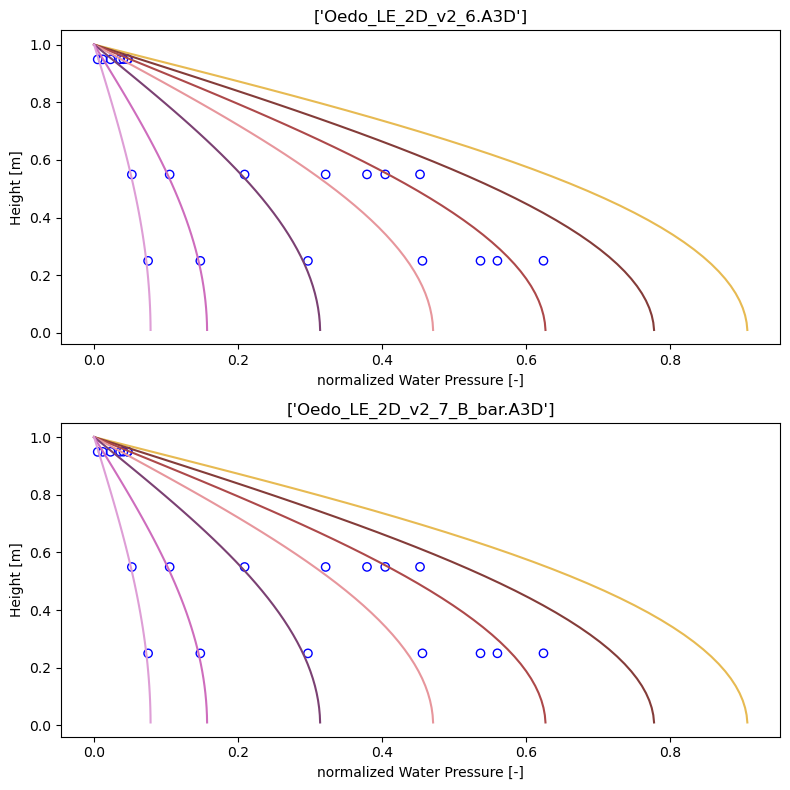

In [408]:
num_rows = 2
num_cols = math.ceil(num_models/num_rows)
fig, axs = plt.subplots(nrows = num_rows, ncols= num_cols, figsize = (8, 8))

num_lines = len(plot_time_factors)
lower_time = 4
upper_time = num_lines

# Generate an array of colors based on a colormap
colormap = plt.cm.tab20b
colors = [colormap(i) for i in np.linspace(0.2, 1, num_lines)]

for i, ax in enumerate(axs.reshape(-1)):
    for j, Tv in enumerate(plot_time_factors[lower_time:upper_time]):
        # Analytical (theoretical) solution calculations
        theo_pressure = calc_terzhagi_pore_pressure(applied_load, spatial_array, init_soil_height, Tv, num_iterations)
        
        # Normalize the pore pressures
        theo_normalized_pressure = calc_normalized_pore_pressure(theo_pressure, applied_load)
        # if Tv == 0:
        #     print(theo_pressure)
        # Plot the solution anlytical for t_i
        ax.plot(theo_normalized_pressure, spatial_array, c= colors[j+lower_time])

for i, ax in enumerate(axs.reshape(-1)[:num_models]):
    # Plot each model independently
    model = results_list[i]

    # Select the data from each MP
    for  mp_data in model.DATA:
        # Select the plot time rows
        plot_df = mp_data.iloc[model_row_indices[i][lower_time:upper_time]]
        
        normalized_pressure = calc_normalized_pore_pressure(-1 * plot_df["WPressure"]*1e3, applied_load)

        # Plot the pressure data 
        ax.scatter(normalized_pressure, plot_df["Y"], marker = "o", facecolors='none', color = "blue")
    
    ax.set_title(model.project)
    ax.set_xlabel("normalized Water Pressure [-]")
    ax.set_ylabel("Height [m]")
    # ax.legend()


plt.tight_layout()

#### Settlement Plot

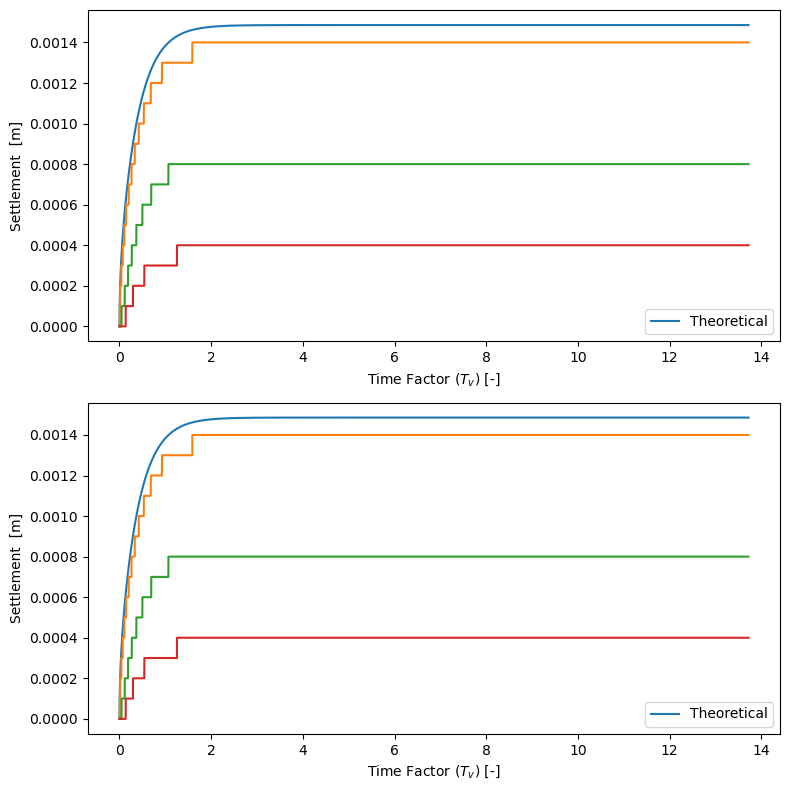

In [409]:
num_rows = 2
num_cols = math.ceil(num_models/num_rows)
fig, axs = plt.subplots(nrows = num_rows, ncols= num_cols, figsize = (8, 8))

for i, model_data in enumerate(results_list):
    # Select the axi handle
    ax = axs.reshape(-1)[i]
    plot_settlement(results_list[0].DATA, ax, plot_theoretical=True)

    # Format Plot
    ax.set_xlabel("Time Factor ($T_{v}$) [-]")
    ax.set_ylabel("Settlement  [m]")
    ax.legend()
plt.tight_layout()